In [1]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch
from os import listdir
from os.path import isfile, join
import numpy as np
from collections import defaultdict

In [2]:
im = Image.open('Rspectrograms/Exhalation_20210427055046_PPCU_HHE_CN_--.png')

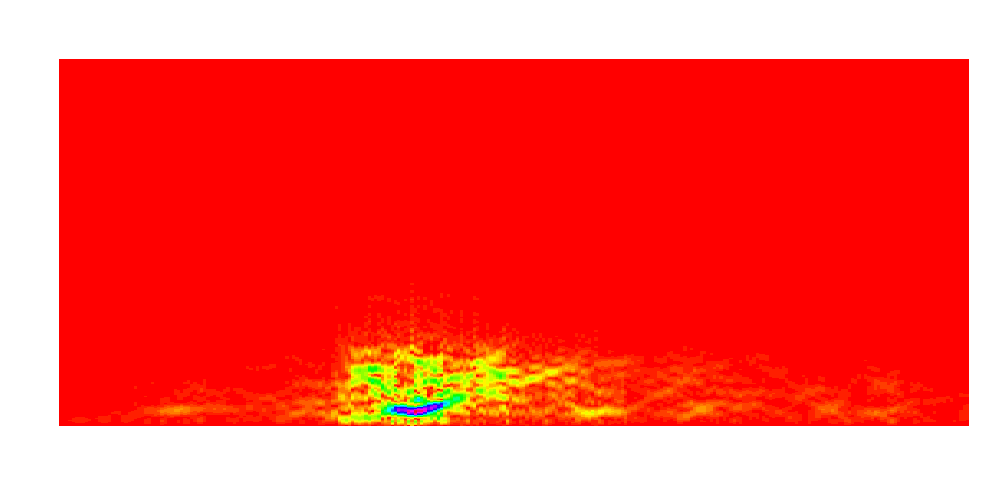

In [3]:
im

In [4]:
array = np.array(im)
array.shape

(500, 1000)

In [5]:
array = np.array(im.convert("RGB")) 
array.shape

(500, 1000, 3)

In [6]:
array.dtype

dtype('uint8')

## Data set from spectrogram images

In [7]:
PATH = 'Rspectrograms/' # where spectrograms are located
CLASS = {'Exhalation': 0, 'Explosions': 1, 'Tremor': 2, 'VTs':3}
FILES = [f for f in listdir(PATH) if isfile(join(PATH, f))]
# key: first word of the file name before the under score, value: label 

read_image = lambda file: Image.open(os.path.join(PATH, file))
get_label = lambda name: CLASS.get(name) 
convert_rgb = lambda image: image.convert('RGB')

Dataset where each spectrogram is considered to be an elemnt 

In [8]:
class LabeledSpectrograms1(Dataset):
    def __init__(self):
        self.X = list()
        self.Y = list()
        for f in FILES:
            clase = f.split('_')[0] 
            self.X.append(f)
            self.Y.append(CLASS[clase])
            
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, index):
        image = self.X[index]
        x = np.array(read_image(image).convert('RGB'), dtype=np.float64)
        x = torch.tensor(x)
        y = torch.tensor(float(self.Y[index]))
        return x, y

In [11]:
dataset = LabeledSpectrograms1()
dataloader = DataLoader(dataset, shuffle=True)
dataloader_it = iter(dataloader)
X, Y = next(dataloader_it)

### Plot image from the data set

Dataset with each element with 3 spectograms as features

In [12]:
X_np = X.cpu().detach().numpy()[0]
X_np = X_np.astype('uint8') 
Y_np = Y.cpu().detach().numpy()[0]

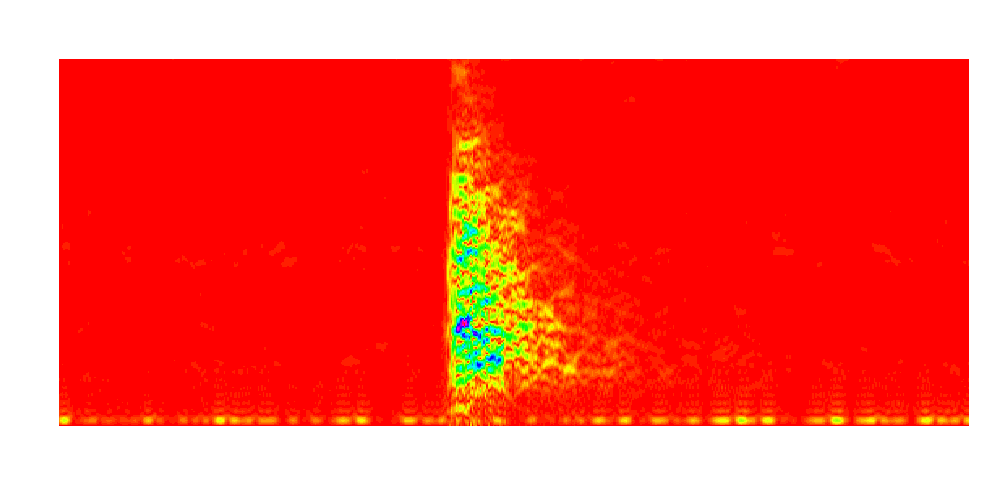

In [15]:
img = Image.fromarray(X_np, 'RGB')
key = next((k for k in CLASS.keys() if CLASS[k] == int(Y_np)), None)
img

In [16]:
print('class: '+key)

class: VTs


In [17]:
class LabeledSpectrograms3(Dataset):
    def __init__(self):
        # list of file names 
        tags = list()
        for f in FILES:
            try:
                clase, date, stn, ch, _, _ = f.split('_')
            except:
                clase, date, stn, ch, _ = f.split('_')
            tags.append(clase + '_' + date + '_' + stn)
        
        tags = set(tags)
        
        self.X = list()
        self.Y = list()
        
        for tag in tags:
            clase, _, _ = tag.split('_')
            other_files = [f for f in FILES if f.startswith(tag)]
            
            if len(other_files) == 3:
                self.X.append(other_files)
                self.Y.append(CLASS[clase])
            
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, index):
        images = self.X[index]
        arrays = [np.array(read_image(im).convert('RGB'), dtype=np.float64) for im in images]
        x = np.concatenate(arrays, axis=-1)
        x = torch.tensor(x)
        y = torch.tensor(float(self.Y[index]))
        return x, y


In [18]:
dataset = LabeledSpectrograms3()

In [19]:
dataloader = DataLoader(dataset, shuffle=True)
dataloader_it = iter(dataloader)
X, Y = next(dataloader_it)

In [20]:
X.shape

torch.Size([1, 500, 1000, 9])